# RNN 长距离依赖问题的直观验证与解决方案

**课程目标**

- 理解长距离依赖问题的具体表现（普通 RNN 在长序列任务中性能下降）
- 掌握 PyTorch 中 RNN/LSTM 的基本实现方法
- 通过对比实验验证 LSTM 对长距离依赖问题的缓解效果

**前置知识**

- 基础 Python 编程能力
- 神经网络基本概念（前向传播、反向传播）
- 序列数据处理的基本思路

# 一、环境搭建（PyTorch）


```bash
# 安装PyTorch（根据操作系统选择对应命令，参考官网：https://pytorch.org/）
# 示例：CPU版本（无需GPU）
conda install pytorch torchvision torchaudio cpuonly -c pytorch

# 安装辅助库
conda install numpy matplotlib pandas
```

# 二、实验任务设计：序列奇偶校验任务

**任务说明**

- **输入**：随机生成的二进制序列（元素为 0 或 1），长度可变（短序列：5-10，长序列：30-50）
- **目标**：预测序列中第一个元素与最后一个元素的异或结果（0⊕0=0，0⊕1=1，1⊕0=1，1⊕1=0）
- **核心难点**：模型必须同时记住 “序列开头” 和 “序列结尾” 的信息（长距离依赖）

# 三、实验步骤

## Step1: 数据生成

In [1]:
import numpy as np
import torch

def generate_data(seq_len, num_samples):
    """
    生成二进制序列及对应的异或标签
    seq_len: 序列长度
    num_samples: 样本数量
    """
    # 生成随机二进制序列 (num_samples, seq_len)
    sequences = np.random.randint(0, 2, size=(num_samples, seq_len))
    # 计算标签：第一个元素与最后一个元素的异或
    labels = (sequences[:, 0] ^ sequences[:, -1]).astype(np.float32)
    
    # 转换为PyTorch张量（增加维度：(num_samples, seq_len, 1)，符合RNN输入格式）
    sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(-1)
    
    return sequences, labels

total_cnt=1000
train_cnt=800

# 生成短序列数据（长度5-10）和长序列数据（长度30-50）
short_seqs, short_labels = generate_data(seq_len=8, num_samples=total_cnt)
long_seqs, long_labels = generate_data(seq_len=90, num_samples=total_cnt)

# 划分训练集和测试集（8:2）
train_short_seqs, test_short_seqs = short_seqs[:train_cnt], short_seqs[train_cnt:]
train_short_labels, test_short_labels = short_labels[:train_cnt], short_labels[train_cnt:]

train_long_seqs, test_long_seqs = long_seqs[:train_cnt], long_seqs[train_cnt:]
train_long_labels, test_long_labels = long_labels[:train_cnt], long_labels[train_cnt:]


## Step2: 定义模型（普通RNN vs LSTM）

In [2]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True  # 输入格式：(batch_size, seq_len, input_size)
        )
        self.fc = nn.Linear(hidden_size, output_size)  # 输出层（二分类）
        self.sigmoid = nn.Sigmoid()  # 激活函数，输出0-1之间的概率

    def forward(self, x):
        # x: (batch_size, seq_len, 1)
        _, hidden = self.rnn(x)  # 只关注最后一个时刻的隐藏状态 (1, batch_size, hidden_size)
        hidden = hidden.squeeze(0)  # 降维为 (batch_size, hidden_size)
        out = self.fc(hidden)
        return self.sigmoid(out)  # 输出预测概率


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM返回：所有时刻输出, (最后时刻隐藏状态, 最后时刻细胞状态)
        _, (hidden, _) = self.lstm(x)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return self.sigmoid(out)


class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # GRU返回：所有时刻输出, 最后时刻隐藏状态
        _, hidden = self.gru(x)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return self.sigmoid(out)


## Step3：训练与评估

Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1041.92it/s]


Epoch 1: Loss=0.6936, Test Acc=0.4450


Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.35it/s]


Epoch 2: Loss=0.6913, Test Acc=0.4450


Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.40it/s]


Epoch 3: Loss=0.6910, Test Acc=0.4450


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.40it/s]


Epoch 4: Loss=0.6908, Test Acc=0.4450


Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.49it/s]


Epoch 5: Loss=0.6907, Test Acc=0.4450


Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1041.66it/s]


Epoch 6: Loss=0.6905, Test Acc=0.4450


Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.38it/s]


Epoch 7: Loss=0.6902, Test Acc=0.4300


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.62it/s]


Epoch 8: Loss=0.6900, Test Acc=0.4450


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.47it/s]


Epoch 9: Loss=0.6897, Test Acc=0.4300


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 10: Loss=0.6893, Test Acc=0.4250


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.47it/s]


Epoch 11: Loss=0.6891, Test Acc=0.4550


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.51it/s]


Epoch 12: Loss=0.6890, Test Acc=0.4650


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.40it/s]


Epoch 13: Loss=0.6889, Test Acc=0.4500


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.45it/s]


Epoch 14: Loss=0.6888, Test Acc=0.4500


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.38it/s]


Epoch 15: Loss=0.6887, Test Acc=0.4500


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 16: Loss=0.6886, Test Acc=0.4500


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.36it/s]


Epoch 17: Loss=0.6885, Test Acc=0.4500


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.49it/s]


Epoch 18: Loss=0.6884, Test Acc=0.4500


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1188.31it/s]


Epoch 19: Loss=0.6883, Test Acc=0.4550


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.06it/s]


Epoch 20: Loss=0.6882, Test Acc=0.4550


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.38it/s]


Epoch 21: Loss=0.6880, Test Acc=0.4750


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 22: Loss=0.6877, Test Acc=0.4750


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.02it/s]


Epoch 23: Loss=0.6874, Test Acc=0.4750


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.09it/s]


Epoch 24: Loss=0.6868, Test Acc=0.4800


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.60it/s]


Epoch 25: Loss=0.6859, Test Acc=0.4950


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1192.85it/s]


Epoch 26: Loss=0.6842, Test Acc=0.4950


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.02it/s]


Epoch 27: Loss=0.6810, Test Acc=0.5250


Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.47it/s]


Epoch 28: Loss=0.6752, Test Acc=0.5200


Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.54it/s]


Epoch 29: Loss=0.6673, Test Acc=0.5050


Epoch 30/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1192.69it/s]


Epoch 30: Loss=0.6582, Test Acc=0.5800


Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 31: Loss=0.6476, Test Acc=0.6300


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.04it/s]


Epoch 32: Loss=0.6350, Test Acc=0.7100


Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1086.97it/s]


Epoch 33: Loss=0.6199, Test Acc=0.7500


Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 34: Loss=0.6022, Test Acc=0.8150


Epoch 35/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1249.97it/s]


Epoch 35: Loss=0.5819, Test Acc=0.8800


Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.02it/s]


Epoch 36: Loss=0.5592, Test Acc=0.9350


Epoch 37/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.49it/s]


Epoch 37: Loss=0.5346, Test Acc=0.9800


Epoch 38/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.51it/s]


Epoch 38: Loss=0.5083, Test Acc=0.9950


Epoch 39/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.36it/s]


Epoch 39: Loss=0.4806, Test Acc=1.0000


Epoch 40/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.49it/s]


Epoch 40: Loss=0.4518, Test Acc=1.0000


Epoch 41/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.51it/s]


Epoch 41: Loss=0.4223, Test Acc=1.0000


Epoch 42/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1041.69it/s]


Epoch 42: Loss=0.3925, Test Acc=1.0000


Epoch 43/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1086.96it/s]


Epoch 43: Loss=0.3629, Test Acc=1.0000


Epoch 44/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1086.92it/s]


Epoch 44: Loss=0.3340, Test Acc=1.0000


Epoch 45/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1136.34it/s]


Epoch 45: Loss=0.3064, Test Acc=1.0000


Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.48it/s]


Epoch 46: Loss=0.2803, Test Acc=1.0000


Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1250.06it/s]


Epoch 47: Loss=0.2561, Test Acc=1.0000


Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.51it/s]


Epoch 48: Loss=0.2338, Test Acc=1.0000


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1195.48it/s]


Epoch 49: Loss=0.2134, Test Acc=1.0000


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 1190.51it/s]


Epoch 50: Loss=0.1949, Test Acc=1.0000


Epoch 1/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.12it/s]


Epoch 1: Loss=0.6939, Test Acc=0.5650


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.27it/s]


Epoch 2: Loss=0.6926, Test Acc=0.5650


Epoch 3/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 301.23it/s]


Epoch 3: Loss=0.6924, Test Acc=0.5650


Epoch 4/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.12it/s]

Epoch 4: Loss=0.6922, Test Acc=0.5700



Epoch 5/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.36it/s]


Epoch 5: Loss=0.6920, Test Acc=0.5600


Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.09it/s]


Epoch 6: Loss=0.6917, Test Acc=0.5600


Epoch 7/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.09it/s]


Epoch 7: Loss=0.6915, Test Acc=0.5550


Epoch 8/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 297.62it/s]


Epoch 8: Loss=0.6912, Test Acc=0.5400


Epoch 9/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.09it/s]

Epoch 9: Loss=0.6909, Test Acc=0.5600



Epoch 10/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.67it/s]


Epoch 10: Loss=0.6906, Test Acc=0.5600


Epoch 11/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 297.62it/s]


Epoch 11: Loss=0.6903, Test Acc=0.5550


Epoch 12/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.70it/s]


Epoch 12: Loss=0.6899, Test Acc=0.5700


Epoch 13/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.09it/s]

Epoch 13: Loss=0.6895, Test Acc=0.5800



Epoch 14/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.10it/s]


Epoch 14: Loss=0.6892, Test Acc=0.6000


Epoch 15/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 299.21it/s]


Epoch 15: Loss=0.6890, Test Acc=0.6100


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 280.90it/s]


Epoch 16: Loss=0.6890, Test Acc=0.6050


Epoch 17/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 280.87it/s]


Epoch 17: Loss=0.6889, Test Acc=0.6000


Epoch 18/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.36it/s]


Epoch 18: Loss=0.6888, Test Acc=0.6000


Epoch 19/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.09it/s]


Epoch 19: Loss=0.6887, Test Acc=0.6050


Epoch 20/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.34it/s]


Epoch 20: Loss=0.6886, Test Acc=0.5950


Epoch 21/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.70it/s]


Epoch 21: Loss=0.6885, Test Acc=0.5900


Epoch 22/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 257.71it/s]


Epoch 22: Loss=0.6883, Test Acc=0.5750


Epoch 23/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 288.61it/s]


Epoch 23: Loss=0.6880, Test Acc=0.5500


Epoch 24/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.61it/s]


Epoch 24: Loss=0.6879, Test Acc=0.5350


Epoch 25/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.12it/s]


Epoch 25: Loss=0.6872, Test Acc=0.5250


Epoch 26/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 294.11it/s]


Epoch 26: Loss=0.6872, Test Acc=0.5500


Epoch 27/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.70it/s]


Epoch 27: Loss=0.6868, Test Acc=0.5500


Epoch 28/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.67it/s]


Epoch 28: Loss=0.6871, Test Acc=0.5600


Epoch 29/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 290.70it/s]


Epoch 29: Loss=0.6865, Test Acc=0.5500


Epoch 30/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.10it/s]


Epoch 30: Loss=0.6866, Test Acc=0.5350


Epoch 31/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.36it/s]


Epoch 31: Loss=0.6861, Test Acc=0.5450


Epoch 32/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.07it/s]


Epoch 32: Loss=0.6857, Test Acc=0.5500


Epoch 33/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.73it/s]


Epoch 33: Loss=0.6858, Test Acc=0.5400


Epoch 34/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.24it/s]


Epoch 34: Loss=0.6858, Test Acc=0.5400


Epoch 35/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.33it/s]


Epoch 35: Loss=0.6858, Test Acc=0.5200


Epoch 36/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 277.78it/s]


Epoch 36: Loss=0.6856, Test Acc=0.5450


Epoch 37/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 280.87it/s]


Epoch 37: Loss=0.6857, Test Acc=0.5350


Epoch 38/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.33it/s]


Epoch 38: Loss=0.6858, Test Acc=0.5450


Epoch 39/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 278.13it/s]


Epoch 39: Loss=0.6863, Test Acc=0.5500


Epoch 40/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.34it/s]


Epoch 40: Loss=0.6854, Test Acc=0.5350


Epoch 41/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 284.09it/s]


Epoch 41: Loss=0.6853, Test Acc=0.5300


Epoch 42/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 287.36it/s]


Epoch 42: Loss=0.6852, Test Acc=0.5500


Epoch 43/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 280.92it/s]


Epoch 43: Loss=0.6861, Test Acc=0.5500


Epoch 44/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.73it/s]


Epoch 44: Loss=0.6852, Test Acc=0.5400


Epoch 45/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.73it/s]


Epoch 45: Loss=0.6846, Test Acc=0.5450


Epoch 46/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 280.90it/s]


Epoch 46: Loss=0.6839, Test Acc=0.5800


Epoch 47/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 277.76it/s]


Epoch 47: Loss=0.6875, Test Acc=0.5400


Epoch 48/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.72it/s]


Epoch 48: Loss=0.6854, Test Acc=0.5250


Epoch 49/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.65it/s]


Epoch 49: Loss=0.6833, Test Acc=0.5700


Epoch 50/50: 100%|████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 274.73it/s]


Epoch 50: Loss=0.6986, Test Acc=0.5100


Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 54.95it/s]


Epoch 1: Loss=0.6931, Test Acc=0.5650


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 57.08it/s]


Epoch 2: Loss=0.6926, Test Acc=0.5650


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.50it/s]


Epoch 3: Loss=0.6925, Test Acc=0.5650


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 51.87it/s]


Epoch 4: Loss=0.6925, Test Acc=0.5650


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 53.08it/s]


Epoch 5: Loss=0.6924, Test Acc=0.5650


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 52.04it/s]


Epoch 6: Loss=0.6924, Test Acc=0.5650


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.98it/s]


Epoch 7: Loss=0.6924, Test Acc=0.5650


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.54it/s]


Epoch 8: Loss=0.6924, Test Acc=0.5650


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.09it/s]


Epoch 9: Loss=0.6924, Test Acc=0.5650


Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.28it/s]


Epoch 10: Loss=0.6923, Test Acc=0.5650


Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.39it/s]


Epoch 11: Loss=0.6923, Test Acc=0.5650


Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 48.25it/s]


Epoch 12: Loss=0.6923, Test Acc=0.5650


Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.98it/s]


Epoch 13: Loss=0.6923, Test Acc=0.5650


Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.26it/s]


Epoch 14: Loss=0.6923, Test Acc=0.5650


Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.80it/s]


Epoch 15: Loss=0.6923, Test Acc=0.5650


Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.44it/s]


Epoch 16: Loss=0.6923, Test Acc=0.5650


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.62it/s]


Epoch 17: Loss=0.6922, Test Acc=0.5650


Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.53it/s]


Epoch 18: Loss=0.6922, Test Acc=0.5650


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.34it/s]


Epoch 19: Loss=0.6922, Test Acc=0.5650


Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.14it/s]


Epoch 20: Loss=0.6922, Test Acc=0.5650


Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.32it/s]


Epoch 21: Loss=0.6922, Test Acc=0.5650


Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.80it/s]


Epoch 22: Loss=0.6921, Test Acc=0.5650


Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.29it/s]


Epoch 23: Loss=0.6921, Test Acc=0.5650


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.21it/s]


Epoch 24: Loss=0.6921, Test Acc=0.5650


Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.54it/s]


Epoch 25: Loss=0.6920, Test Acc=0.5700


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.82it/s]


Epoch 26: Loss=0.6920, Test Acc=0.5900


Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.13it/s]


Epoch 27: Loss=0.6918, Test Acc=0.5500


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.17it/s]


Epoch 28: Loss=0.6916, Test Acc=0.5650


Epoch 29/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.87it/s]


Epoch 29: Loss=0.6912, Test Acc=0.5550


Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.47it/s]


Epoch 30: Loss=0.6919, Test Acc=0.5600


Epoch 31/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.45it/s]


Epoch 31: Loss=0.6976, Test Acc=0.4700


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.64it/s]


Epoch 32: Loss=0.6938, Test Acc=0.5650


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.96it/s]


Epoch 33: Loss=0.6924, Test Acc=0.5650


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.30it/s]


Epoch 34: Loss=0.6923, Test Acc=0.5650


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.75it/s]


Epoch 35: Loss=0.6923, Test Acc=0.5650


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.72it/s]


Epoch 36: Loss=0.6923, Test Acc=0.5650


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.35it/s]


Epoch 37: Loss=0.6922, Test Acc=0.5650


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.23it/s]


Epoch 38: Loss=0.6922, Test Acc=0.5650


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 47.56it/s]


Epoch 39: Loss=0.6922, Test Acc=0.5650


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 44.84it/s]


Epoch 40: Loss=0.6922, Test Acc=0.5650


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.21it/s]


Epoch 41: Loss=0.6922, Test Acc=0.5650


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.00it/s]


Epoch 42: Loss=0.6922, Test Acc=0.5650


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.45it/s]


Epoch 43: Loss=0.6922, Test Acc=0.5650


Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.37it/s]


Epoch 44: Loss=0.6922, Test Acc=0.5650


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.47it/s]


Epoch 45: Loss=0.6922, Test Acc=0.5650


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 43.40it/s]


Epoch 46: Loss=0.6922, Test Acc=0.5650


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.64it/s]


Epoch 47: Loss=0.6922, Test Acc=0.5650


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.21it/s]


Epoch 48: Loss=0.6922, Test Acc=0.5650


Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 46.21it/s]


Epoch 49: Loss=0.6922, Test Acc=0.5650


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.79it/s]


Epoch 50: Loss=0.6922, Test Acc=0.5650


Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 79.87it/s]


Epoch 1: Loss=0.6930, Test Acc=0.5650


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 82.51it/s]


Epoch 2: Loss=0.6925, Test Acc=0.5650


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 83.06it/s]


Epoch 3: Loss=0.6925, Test Acc=0.5650


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 84.46it/s]


Epoch 4: Loss=0.6924, Test Acc=0.5650


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 85.61it/s]


Epoch 5: Loss=0.6924, Test Acc=0.5650


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 82.78it/s]


Epoch 6: Loss=0.6924, Test Acc=0.5650


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 85.32it/s]


Epoch 7: Loss=0.6923, Test Acc=0.5650


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 84.75it/s]


Epoch 8: Loss=0.6923, Test Acc=0.5650


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.94it/s]


Epoch 9: Loss=0.6923, Test Acc=0.5650


Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 89.61it/s]


Epoch 10: Loss=0.6922, Test Acc=0.5650


Epoch 11/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.08it/s]


Epoch 11: Loss=0.6922, Test Acc=0.5650


Epoch 12/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 89.41it/s]


Epoch 12: Loss=0.6922, Test Acc=0.5650


Epoch 13/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.64it/s]


Epoch 13: Loss=0.6922, Test Acc=0.5650


Epoch 14/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 81.78it/s]


Epoch 14: Loss=0.6922, Test Acc=0.5650


Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.64it/s]


Epoch 15: Loss=0.6921, Test Acc=0.5650


Epoch 16/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.37it/s]


Epoch 16: Loss=0.6921, Test Acc=0.5650


Epoch 17/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 91.23it/s]


Epoch 17: Loss=0.6921, Test Acc=0.5650


Epoch 18/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.05it/s]


Epoch 18: Loss=0.6921, Test Acc=0.5650


Epoch 19/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.72it/s]


Epoch 19: Loss=0.6921, Test Acc=0.5650


Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.15it/s]


Epoch 20: Loss=0.6921, Test Acc=0.5650


Epoch 21/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.30it/s]


Epoch 21: Loss=0.6921, Test Acc=0.5700


Epoch 22/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.82it/s]


Epoch 22: Loss=0.6921, Test Acc=0.5800


Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.34it/s]


Epoch 23: Loss=0.6921, Test Acc=0.5850


Epoch 24/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.66it/s]


Epoch 24: Loss=0.6920, Test Acc=0.6000


Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.64it/s]


Epoch 25: Loss=0.6920, Test Acc=0.5850


Epoch 26/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.09it/s]


Epoch 26: Loss=0.6920, Test Acc=0.5650


Epoch 27/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.28it/s]


Epoch 27: Loss=0.6920, Test Acc=0.5450


Epoch 28/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.63it/s]


Epoch 28: Loss=0.6920, Test Acc=0.5350


Epoch 29/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.25it/s]


Epoch 29: Loss=0.6920, Test Acc=0.5350


Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 96.52it/s]


Epoch 30: Loss=0.6920, Test Acc=0.5450


Epoch 31/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.28it/s]


Epoch 31: Loss=0.6920, Test Acc=0.5500


Epoch 32/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.04it/s]


Epoch 32: Loss=0.6920, Test Acc=0.5450


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 91.24it/s]


Epoch 33: Loss=0.6920, Test Acc=0.5450


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.79it/s]


Epoch 34: Loss=0.6919, Test Acc=0.5400


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.24it/s]


Epoch 35: Loss=0.6919, Test Acc=0.5400


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.42it/s]


Epoch 36: Loss=0.6919, Test Acc=0.5450


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.43it/s]


Epoch 37: Loss=0.6919, Test Acc=0.5400


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.29it/s]


Epoch 38: Loss=0.6919, Test Acc=0.5400


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.07it/s]


Epoch 39: Loss=0.6918, Test Acc=0.5400


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.34it/s]


Epoch 40: Loss=0.6918, Test Acc=0.5400


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.34it/s]


Epoch 41: Loss=0.6918, Test Acc=0.5400


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 97.05it/s]


Epoch 42: Loss=0.6917, Test Acc=0.5350


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 96.16it/s]


Epoch 43: Loss=0.6916, Test Acc=0.5300


Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.58it/s]


Epoch 44: Loss=0.6915, Test Acc=0.5250


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 87.11it/s]


Epoch 45: Loss=0.6913, Test Acc=0.5400


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 97.66it/s]


Epoch 46: Loss=0.6910, Test Acc=0.5450


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.04it/s]


Epoch 47: Loss=0.6904, Test Acc=0.5550


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 93.63it/s]


Epoch 48: Loss=0.6901, Test Acc=0.5550


Epoch 49/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.42it/s]


Epoch 49: Loss=0.6893, Test Acc=0.5550


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.04it/s]


Epoch 50: Loss=0.6892, Test Acc=0.5600


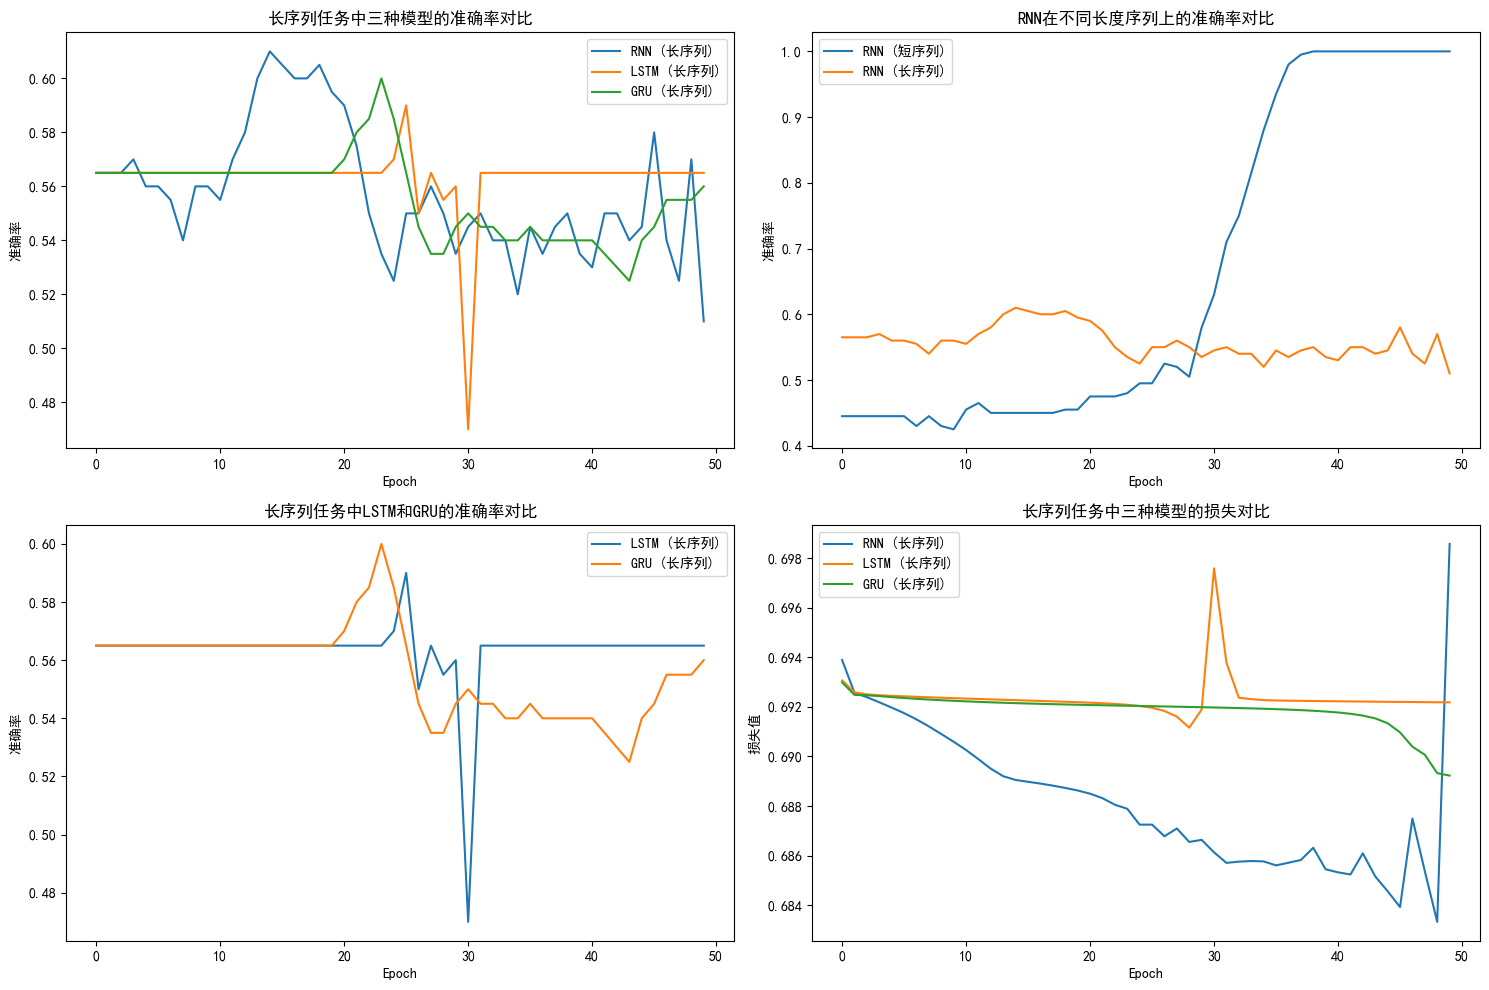

In [3]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Zen Hei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 超参数
epochs = 50
batch_size = 32
lr = 0.001

def train_model(model, train_seqs, train_labels, test_seqs, test_labels, epochs, batch_size, lr):
    criterion = nn.BCELoss()  # 二分类交叉熵损失
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_accs = []
    
    # 计算批次数量
    num_batches = len(train_seqs) // batch_size
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        # 批量训练
        for i in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}"):
            start = i * batch_size
            end = start + batch_size
            batch_seqs = train_seqs[start:end]
            batch_labels = train_labels[start:end]
            
            optimizer.zero_grad()
            outputs = model(batch_seqs)
            loss = criterion(outputs, batch_labels)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            total_loss += loss.item()
        
        # 计算平均训练损失
        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)
        
        # 测试集评估准确率
        model.eval()
        with torch.no_grad():
            outputs = model(test_seqs)
            preds = (outputs > 0.5).float()  # 概率>0.5视为1，否则0
            acc = (preds == test_labels).float().mean().item()
            test_accs.append(acc)
        
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Test Acc={acc:.4f}")
    
    return train_losses, test_accs

# 1. 训练普通RNN（短序列）
rnn_short = SimpleRNN()
rnn_short_losses, rnn_short_accs = train_model(
    rnn_short, train_short_seqs, train_short_labels,
    test_short_seqs, test_short_labels,
    epochs=epochs, batch_size=batch_size, lr=lr
)

# 2. 训练普通RNN（长序列）
rnn_long = SimpleRNN()
rnn_long_losses, rnn_long_accs = train_model(
    rnn_long, train_long_seqs, train_long_labels,
    test_long_seqs, test_long_labels,
    epochs=epochs, batch_size=batch_size, lr=lr
)

# 3. 训练LSTM（长序列）
lstm_long = LSTMModel()
lstm_long_losses, lstm_long_accs = train_model(
    lstm_long, train_long_seqs, train_long_labels,
    test_long_seqs, test_long_labels,
    epochs=epochs, batch_size=batch_size, lr=lr
)

# 4. 训练GRU（长序列）
gru_long = GRUModel()
gru_long_losses, gru_long_accs = train_model(
    gru_long, train_long_seqs, train_long_labels,
    test_long_seqs, test_long_labels,
    epochs=epochs, batch_size=batch_size, lr=lr
)

# 绘制结果对比图
plt.figure(figsize=(15, 10))

# 图1：长序列任务中三种模型的准确率对比
plt.subplot(2, 2, 1)
plt.plot(rnn_long_accs, label="RNN (长序列)")
plt.plot(lstm_long_accs, label="LSTM (长序列)")
plt.plot(gru_long_accs, label="GRU (长序列)")
plt.title("长序列任务中三种模型的准确率对比")
plt.xlabel("Epoch")
plt.ylabel("准确率")
plt.legend()

# 图2：RNN在不同长度序列上的准确率对比
plt.subplot(2, 2, 2)
plt.plot(rnn_short_accs, label="RNN (短序列)")
plt.plot(rnn_long_accs, label="RNN (长序列)")
plt.title("RNN在不同长度序列上的准确率对比")
plt.xlabel("Epoch")
plt.ylabel("准确率")
plt.legend()

# 图3：长序列任务中LSTM和GRU的准确率对比
plt.subplot(2, 2, 3)
plt.plot(lstm_long_accs, label="LSTM (长序列)")
plt.plot(gru_long_accs, label="GRU (长序列)")
plt.title("长序列任务中LSTM和GRU的准确率对比")
plt.xlabel("Epoch")
plt.ylabel("准确率")
plt.legend()

# 图4：三种模型在长序列任务上的损失对比
plt.subplot(2, 2, 4)
plt.plot(rnn_long_losses, label="RNN (长序列)")
plt.plot(lstm_long_losses, label="LSTM (长序列)")
plt.plot(gru_long_losses, label="GRU (长序列)")
plt.title("长序列任务中三种模型的损失对比")
plt.xlabel("Epoch")
plt.ylabel("损失值")
plt.legend()

plt.tight_layout()
plt.show()


# 四、预期实验结果与分析

1. **三种模型在长序列任务中的表现对比：**

    - 普通 RNN：准确率停留在 50% 左右（接近随机猜测），无法捕捉长距离依赖
    - LSTM：准确率可达 90% 以上，能够有效记忆序列开头和结尾的信息
    - GRU：准确率与 LSTM 接近（略低或基本相当），同样能解决长距离依赖问题

2. GRU 与 LSTM 的异同：
    - 相同点：两者都通过门控机制解决了梯度消失 / 爆炸问题，能够处理长距离依赖
    - 不同点：GRU 参数更少（没有细胞状态和输出门），训练速度略快；LSTM 结构更复杂，在某些复杂任务上可能表现更稳定

3. 性能差异的原因：
    - 普通 RNN 由于简单的循环结构，在长序列上梯度消失严重，无法传递远距离信息
    - LSTM 通过遗忘门、输入门和输出门精确控制信息的流动和记忆
    - GRU 通过更新门和重置门实现类似功能，结构更简洁，计算效率更高

# 五、扩展思考与任务